## Empirical downscaling with calibration from point measurements

In [1]:
import xarray
import pandas as pd
import matplotlib.pyplot as plt
import seaborn
import numpy as np
from skimage.restoration import denoise_bilateral, denoise_wavelet
# import Py6S

from sklearn.base import BaseEstimator
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, KernelPCA
from sklearn.gaussian_process.kernels import WhiteKernel, ConstantKernel, Matern

def stack(x, geometry=False):
    _stacked = x.stack(pix=['row','col'])
    if geometry:
        return np.vstack([_stacked.row.values, _stacked.col.values]).T
    return np.atleast_2d(_stacked.values)

def preprocess_hsi(x, data_var='var_',
                   geometry_vars=[]):
    xnew=[]
    xnew.append(stack(x[data_var]))
    for v in geometry_vars:
        xnew.append(stack(x[v]))
    return np.concatenate(xnew).T

def to_xarray(x, shape=(100,100,5)):
    return xarray.DataArray(x.reshape(shape).T,
                         dims=['dim0','col','row']).transpose('dim0', 'row', 'col')

def get_pix_n(xs, ys):
    lookup = np.arange(10000).reshape((100,100))
    return lookup[ys, xs]

def get_window_n(xs, ys, k=[-1,0,1]):
    """same as get_pix_n but retrieves a windowed region around point
    """
    out = []
    for i in k:
        for j in k:
            out.append(get_pix_n(xs+i, ys+j))
    return np.concatenate(out)

def pad_and_resample(da, window_size=10):
    _da = da.bfill('col'
                  ).ffill('col'
                         ).bfill('row'
                                ).ffill('row')
    return _da.rolling({'col': window_size,
                        'row': window_size},
                       center=True
                      ).mean()

class RobustScaler1D(RobustScaler):
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def fit(self, X, y=None):
        super().fit(X.reshape((-1,1)), y)
    
    def transform(self, X):
        X_new = super().transform(X.reshape((-1,1)))
        return X_new.ravel()
    
    def fit_transform(self, X, y=None):
        _X = X.reshape((-1,1))
        X_new = super().fit(_X).transform(_X)
        return X_new.ravel()
    
    def inverse_transform(self, X):
        try:
            _X = X.reshape((-1,1))
            return super().inverse_transform(_X).ravel()
        except AttributeError:
            mu = super().inverse_transform(X[0].reshape((-1,1))).ravel()
            lwr = super().inverse_transform((X[0] - X[1]).reshape((-1,1))).ravel()
            SE = mu - lwr
            return mu, SE

In [2]:
aerial_F = xarray.open_dataset('data/SSC_SENSECOWG1/1_SSC_data/Airborne_F.nc')
aerial_HSI = xarray.open_dataset('data/SSC_SENSECOWG1/1_SSC_data/Airborne_HDRF.nc')
aerial_LST = xarray.open_dataset('data/SSC_SENSECOWG1/1_SSC_data/Airborne_LST.nc')
field_data = pd.read_csv('data/SSC_SENSECOWG1/1_SSC_data/FieldData.csv')
field_data2 = pd.read_csv('data/SSC_SENSECOWG1/1_SSC_data/FieldData_hh.csv')
# aerial_HSI = aerial_HSI.rolling({'row':2, 'col':2}).median().fillna(0)

In [3]:
field_data.head()

,PlotNum,Xutm,Yutm,Xpix,Ypix,Crop,LAI,Cab,Vcmax25_time,Vcmax25,...,NPQ1,NPQ2_time,NPQ2,ceptometer_time,PARin,PARbottom,PARrefl_top,PARrefl_soil,aPAR,faPAR
0,1,262731.5,4426243.5,10,18,Wheat,5.826482,44.093413,01-Jul-2019 07:05:00,39.473392,...,0.962644,01-Jul-2019 11:12:22,1.289874,01-Jul-2019 13:19:23,2250.212852,8.184406,64.869923,18.427543,2195.586065,0.975724
1,2,262731.5,4426210.5,10,51,Wheat,5.754653,40.553934,01-Jul-2019 10:25:11,19.444781,...,1.312276,01-Jul-2019 10:54:32,1.609896,01-Jul-2019 13:09:23,2220.429705,11.136204,67.610225,21.603950,2163.287226,0.974265
2,3,262731.5,4426178.5,10,83,Wheat,4.945238,36.305830,02-Jul-2019 07:05:42,18.455669,...,1.672394,01-Jul-2019 12:06:42,1.859076,01-Jul-2019 12:43:21,2269.026828,17.711758,71.997041,31.327445,2210.645475,0.974270
3,4,262747.5,4426243.5,26,18,Wheat,5.815774,44.134000,01-Jul-2019 07:45:11,36.264345,...,0.814022,01-Jul-2019 11:00:26,1.024051,01-Jul-2019 12:59:07,2229.476497,8.549078,66.009388,17.678330,2172.596362,0.974487
4,5,262747.5,4426210.5,26,51,Wheat,5.734290,39.722956,01-Jul-2019 09:45:10,17.881415,...,1.280590,01-Jul-2019 12:24:34,1.381275,01-Jul-2019 14:08:44,2128.679323,10.162841,67.330006,17.205326,2068.391802,0.971678


# LAI
- Decompose HSI to a lower dimensional subspace
- fit a Gaussian Process Regressor to the reprojected HSI

Text(0.5, 1.0, 'LAI')

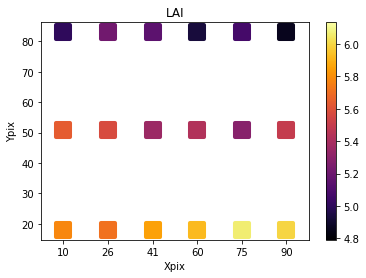

In [4]:
cvar = 'LAI'
ax = seaborn.pointplot(data=field_data, x='Xpix', y='Ypix',
                       hue=cvar, palette='inferno', markers='s',scale=2)

norm = plt.Normalize(field_data[cvar].min(), field_data[cvar].max())
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm)
ax.set_title(cvar)

## PCA N_components estimation


In [7]:
aerial_HSI_filtered = aerial_HSI['var_'].rolling({'bands':3}, center=True).mean().bfill('bands').ffill('bands')
# aerial_HSI_filtered = aerial_HSI_filtered.rolling({'row':5,'col':5}, center=True).mean().bfill('row').ffill('row').ffill('col').bfill('col')
# aerial_HSI_filtered.isel(col=20,row=20).plot()

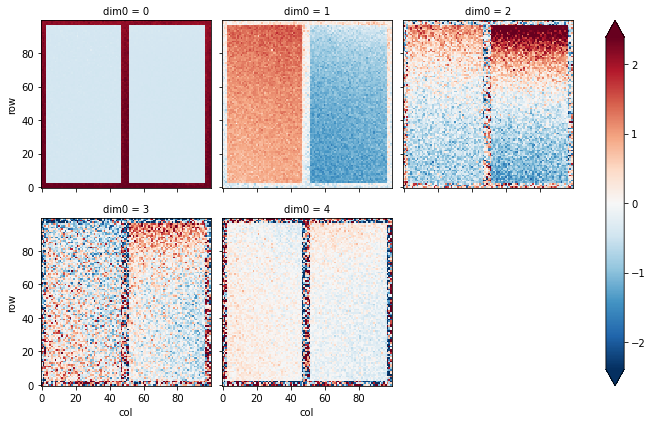

In [8]:
N_COMPONENTS = 5

spectral_decomposer = Pipeline(
    [('rescale', RobustScaler(unit_variance=True)),
     ('pca', PCA(n_components=N_COMPONENTS))])

PCs = to_xarray(spectral_decomposer.fit_transform(
    stack(aerial_HSI_filtered).T), (100, 100, -1))

# scale each PC to 0 mean and var 1
try:
    ((PCs - PCs.mean(['row','col'])) / PCs.std(['row','col'])
    ).plot(col='dim0', col_wrap=3, robust=True)
    # PCs.plot(col='dim0', col_wrap=3, robust=True)
except:
    PCs.plot(robust=True)

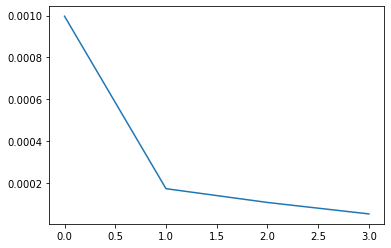

In [9]:
# ignore first component
plt.plot(spectral_decomposer['pca'].explained_variance_ratio_[1:])

Looks like only the first 4 principal components contain information and the others are dominated by noise (the slight plot effect in higher order PCs is probably because the noise is Poisson for image data, so increased variance with signal).

We can just use the first 4 PCs which should account for plot v. non plot, different plots and within plot gradients

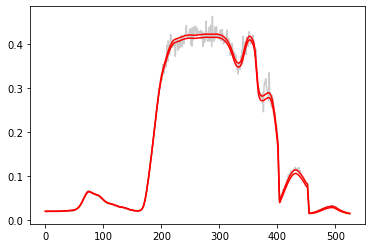

In [10]:
plt.plot(stack(aerial_HSI['var_']).T[325], c='k', alpha=.2)
plt.plot(spectral_decomposer.inverse_transform(PCs.values.reshape((-1, 10000)).T)[325],c='r')
plt.plot(spectral_decomposer.inverse_transform(PCs.values.reshape((-1, 10000)).T)[320],c='r')

# plt.plot(spectral_decomposer.inverse_transform(PCs.values.reshape((-1, 10000)).T)[326])

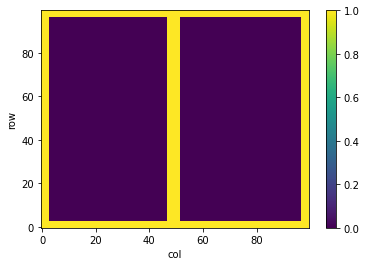

In [11]:
field_boundary = PCs.isel(dim0=0) >= 0
field_boundary.plot()

In [12]:
# Preprocess the array data
# s_1 = preprocess_hsi(aerial_HSI)
# spectral_decomposer = Pipeline(
#     [('rescale', RobustScaler()),
#      ('pca', PCA(n_components=N_COMPONENTS))])

# Do a PCA decomposition of spectral component only
# pca_1 = spectral_decomposer.fit_transform(s_1)

# add positional index for GPC
# gpr_input = np.concatenate([preprocess_hsi(xarray.Dataset({'var_':PCs})),
#                             stack(aerial_HSI, geometry=True)],
#                            1)
gpr_input = preprocess_hsi(xarray.Dataset({'var_':PCs}))

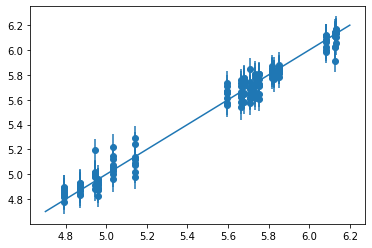

In [15]:
# get the PC features and labels from field data

X = gpr_input[get_window_n(field_data['Xpix']-1, field_data['Ypix']-1, [-1,0,1]),...]

lai_scaler = RobustScaler1D()

y = lai_scaler.fit_transform(np.tile(field_data['LAI'].values, 9))

# Specify Gaussian Kernel
kernel = Matern(length_scale=np.ones(N_COMPONENTS), nu=5/2, length_scale_bounds=[.1, 1e8]) + \
WhiteKernel() 


GPR_LA = Pipeline([
    #('rescale', RobustScaler()),
    #('PCA', PCA(n_components=N_COMPONENTS)),
     ('rescale_pca', MinMaxScaler()),
     ('regressor', GaussianProcessRegressor(kernel=kernel))]
)

# Fit the GPR
GPR_LA.fit(X, y)

_X = gpr_input[get_window_n(field_data['Xpix']-1, field_data['Ypix']-1, [-1,0,1]), :]
_y, _std = lai_scaler.inverse_transform(GPR_LA.predict(_X, return_std=True))
plt.scatter(np.tile(field_data['LAI'].values, 9),
            _y)
plt.errorbar(np.tile(field_data['LAI'].values, 9),
             _y,
             _std,
             fmt='none')
plt.plot(np.linspace(4.7, 6.2),np.linspace(4.7, 6.2))

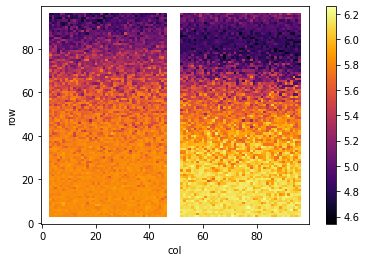

In [32]:
_prediction_LA, _SE_LA = lai_scaler.inverse_transform(GPR_LA.predict(gpr_input, return_std=True))
prediction_LA = field_boundary.copy()
prediction_LA.values = _prediction_LA.reshape((100,100))
prediction_LA = prediction_LA.where(~field_boundary)

prediction_LA_SE = field_boundary.copy().where(~field_boundary)
prediction_LA_SE.values = _SE_LA.reshape((100,100))
prediction_LA_SE = prediction_LA_SE.where(~field_boundary)

# 4x4 median filtering
prediction_LA = pad_and_resample(prediction_LA, window_size=1)
prediction_LA.where(~field_boundary).plot(cmap="inferno")

In [17]:
GPR_LA['regressor'].kernel_

Matern(length_scale=[1.3, 0.344, 0.464, 1.09, 3.89], nu=2.5) + WhiteKernel(noise_level=0.0111)

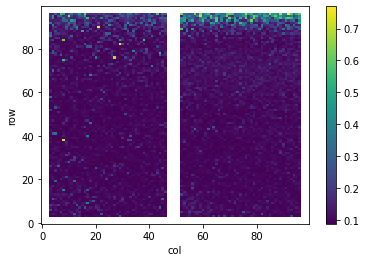

In [18]:
prediction_LA_SE.plot()

# Chlorophyll concentration

Text(0.5, 1.0, 'Cab')

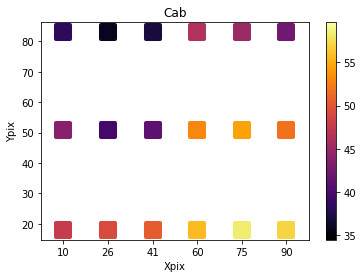

In [19]:
cvar = 'Cab'
ax = seaborn.pointplot(data=field_data, x='Xpix', y='Ypix',
                       hue=cvar, palette='inferno', markers='s',scale=2)

norm = plt.Normalize(field_data[cvar].min(), field_data[cvar].max())
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm)
ax.set_title(cvar)

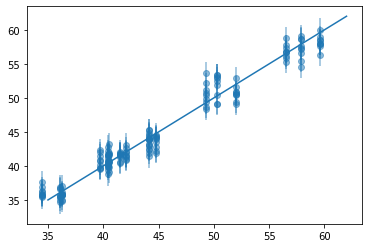

In [26]:
# get the PC features and labels from field data
cab_scaler = RobustScaler1D()
y2 = cab_scaler.fit_transform(np.tile(field_data['Cab'].values, 9))

# Specify Gaussian Kernel
kernel = Matern(length_scale=np.ones(N_COMPONENTS), nu=5/2) + \
WhiteKernel()

GPR_cab = Pipeline([
    #('rescale', RobustScaler()),
    #('PCA', PCA(n_components=N_COMPONENTS)),
     ('rescale_pca', MinMaxScaler()),
     ('regressor', GaussianProcessRegressor(kernel=kernel))]
)


# Fit the GPR
GPR_cab.fit(X, y2)

# _X = gpr_input[get_pix_n(field_data['Xpix']-1, field_data['Ypix']-1), :]
_y2, _y2SE = cab_scaler.inverse_transform(GPR_cab.predict(_X, return_std=True))

plt.scatter(cab_scaler.inverse_transform(y2),
            _y2, alpha=.5)
plt.errorbar(cab_scaler.inverse_transform(y2),
             _y2,
             _y2SE,
             alpha=.5,
             fmt='none')
plt.plot(np.linspace(35,62),np.linspace(35,62))

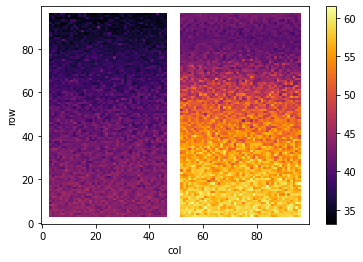

In [33]:
# prediction_cab, _SE_cab = GPR_cab.predict(gpr_input, return_std=True)
# plt.imshow(prediction_cab.reshape((100,100)) * 10,
#            origin='lower', cmap='inferno')
# plt.colorbar()GPR_LA.predict(gpr_input, return_std=True)

_prediction_cab, _SE_cab = cab_scaler.inverse_transform(GPR_cab.predict(gpr_input, return_std=True))
prediction_cab = field_boundary.copy()
prediction_cab.values = _prediction_cab.reshape((100,100))
prediction_cab = prediction_cab.where(~field_boundary)

prediction_cab_SE = field_boundary.copy().where(~field_boundary)
prediction_cab_SE.values = _SE_cab.reshape((100,100))
prediction_cab_SE = prediction_cab_SE.where(~field_boundary)
    
prediction_cab = pad_and_resample(prediction_cab, window_size=1)
prediction_cab.where(~field_boundary).plot(cmap="inferno")

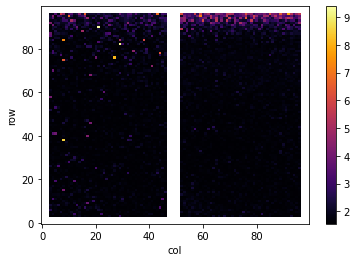

In [34]:
prediction_cab_SE.plot(cmap="inferno")

In [35]:
GPR_cab['regressor'].kernel_

Matern(length_scale=[1.4, 0.421, 0.952, 1.79, 3.16e+04], nu=2.5) + WhiteKernel(noise_level=0.0234)

# VCmax
- use chlorophyll map as feature
- use temperature and V

Text(0.5, 1.0, 'Vcmax25')

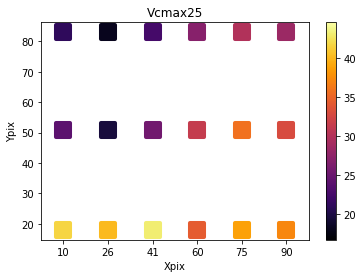

In [36]:
cvar = 'Vcmax25'
ax = seaborn.pointplot(data=field_data, x='Xpix', y='Ypix',
                       hue=cvar, palette='inferno', markers='s',scale=2)

norm = plt.Normalize(field_data[cvar].min(), field_data[cvar].max())
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm)
ax.set_title(cvar)

In [49]:
vcmax_scaler = RobustScaler1D()

gpr_input2 = np.vstack([
    stack(prediction_cab.fillna(0)),
    # gpr_input.T
    # stack(prediction_LA.fillna(0)),
    # stack(aerial_LST['var_'].isel(bands=0)).ravel(),
    # stack(aerial_F['var_'].isel(bands=0)).ravel(),
    # stack(aerial_F['var_'].isel(bands=1)).ravel()
]).T

X3 = gpr_input[get_window_n(field_data['Xpix']-1, field_data['Ypix']-1, [-1,0,1]),...]
y3 = np.tile(vcmax_scaler.fit_transform(field_data['Vcmax25'].values),9)

In [50]:
from sklearn.linear_model import LinearRegression

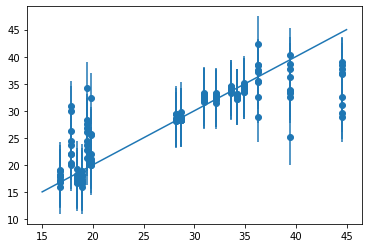

In [51]:
# Specify Gaussian Kernel
kernel = Matern(length_scale=np.ones(X3.shape[1]), nu=5/2) + \
WhiteKernel() 


GPR_vcmax = Pipeline(
    [('rescale_pca', RobustScaler()),
     ('regressor', GaussianProcessRegressor(kernel=kernel))]
)

# Fit the GPR
GPR_vcmax.fit(X3, y3)

# _X = gpr_input[get_pix_n(field_data['Xpix']-1, field_data['Ypix']-1), :]
# _y = field_data['LAI']
y_pred, y_err = vcmax_scaler.inverse_transform(GPR_vcmax.predict(X3, return_std=True))
y_mu = vcmax_scaler.inverse_transform(y3)

plt.scatter(y_mu,
            y_pred)

plt.errorbar(y_mu,
             y_pred,
             y_err,
             fmt='none')
plt.plot(np.linspace(15, 45),np.linspace(15, 45))

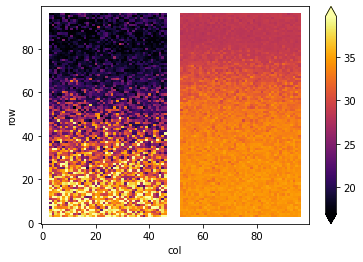

In [53]:
_prediction_vcm, _SE_vcm = vcmax_scaler.inverse_transform(GPR_vcmax.predict(gpr_input, return_std=True))
prediction_vcm = field_boundary.copy()
prediction_vcm.values = _prediction_vcm.reshape((100,100))
prediction_vcm = prediction_vcm.where(~field_boundary)

prediction_vcm_SE = field_boundary.copy().where(~field_boundary)
prediction_vcm_SE.values = _SE_vcm.reshape((100,100))
prediction_vcm_SE = prediction_vcm_SE.where(~field_boundary)
    
prediction_vcm.plot(cmap="inferno", robust=True)

## NPQ

Text(0.5, 1.0, 'NPQ1')

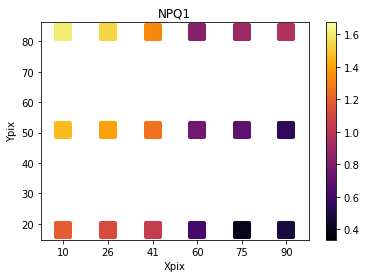

In [54]:
cvar = 'NPQ1'
ax = seaborn.pointplot(data=field_data, x='Xpix', y='Ypix',
                       hue=cvar, palette='inferno', markers='s',scale=2)

norm = plt.Normalize(field_data[cvar].min(), field_data[cvar].max())
sm = plt.cm.ScalarMappable(cmap="inferno", norm=norm)
sm.set_array([])

ax.get_legend().remove()
ax.figure.colorbar(sm)
ax.set_title(cvar)

In [66]:
npq_scaler = RobustScaler1D()

gpr_input3 = np.vstack([
    # stack(prediction_cab.fillna(0)),
    stack(prediction_LA.fillna(0)),
    stack(aerial_F['var_'].isel(bands=0)).ravel(),
    stack(aerial_F['var_'].isel(bands=1)).ravel()
]).T

X4 = gpr_input3[get_window_n(field_data['Xpix']-1, field_data['Ypix']-1, [-2,-1,0,1,2]),...]
y4 = np.tile(npq_scaler.fit_transform(field_data['NPQ1'].values), 25)

/STEM/data/project/users/jf9942/anaconda3/envs/jlabs/lib/python3.9/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


<ErrorbarContainer object of 3 artists>

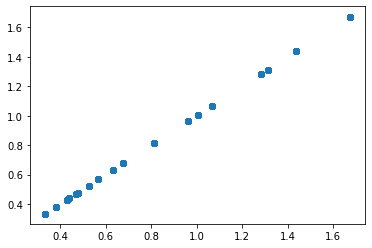

In [67]:
# Specify Gaussian Kernel
kernel = Matern(length_scale=np.ones(X4.shape[1]), nu=5/2) + \
WhiteKernel() 


GPR_npq = Pipeline(
    [('rescale_pca', RobustScaler()),
     ('regressor', GaussianProcessRegressor(kernel=kernel))]
)

# Fit the GPR
GPR_npq.fit(X4, y4)

# _X = gpr_input[get_pix_n(field_data['Xpix']-1, field_data['Ypix']-1), :]
# _y = field_data['LAI']
y_pred, y_err = npq_scaler.inverse_transform(GPR_npq.predict(X4, return_std=True))
y_mu = npq_scaler.inverse_transform(y4)

plt.scatter(y_mu,
            y_pred)

plt.errorbar(y_mu,
             y_pred,
             y_err,
             fmt='none')
# plt.plot(np.linspace(15, 45),np.linspace(15, 45)

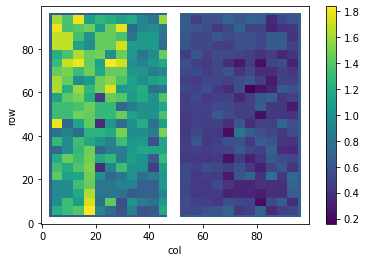

In [68]:
_prediction_npq, _SE_npq = npq_scaler.inverse_transform(GPR_npq.predict(gpr_input3, return_std=True))
prediction_npq = field_boundary.copy()
prediction_npq.values = _prediction_npq.reshape((100,100))
prediction_npq = prediction_npq.where(~field_boundary)

prediction_npq_SE = field_boundary.copy().where(~field_boundary)
prediction_npq_SE.values = _SE_npq.reshape((100,100))
prediction_npq_SE = prediction_npq_SE.where(~field_boundary)
    
prediction_npq.plot()

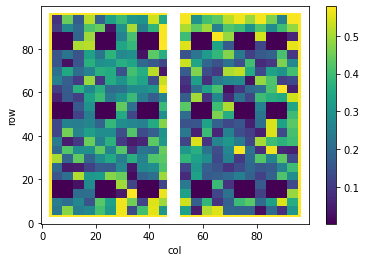

In [69]:
prediction_npq_SE.plot()